In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import time

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(trainloader)*64

50048

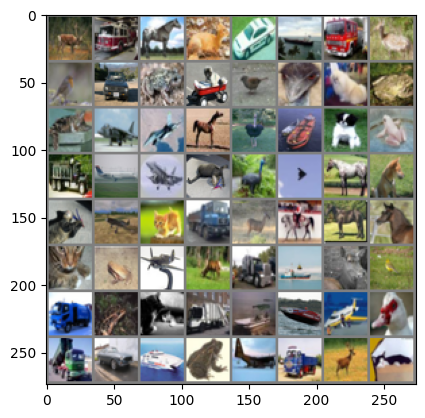

deer  truck horse deer  car   ship  truck deer  bird  car   frog  dog   bird  bird  dog   frog  cat   plane plane horse bird  ship  dog   frog  truck plane plane cat   bird  plane horse dog   cat   plane cat   truck deer  horse horse horse cat   frog  plane deer  truck ship  deer  bird  truck frog  cat   truck ship  ship  plane bird  truck car   ship  frog  plane truck deer  cat  


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
images, labels = next(dataiter)
images.shape

torch.Size([64, 3, 32, 32])

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5,padding='same')#32
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(16, 32, 5,padding='same')#16
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3=nn.Conv2d(32,44,5,padding='same')#8
        self.bn3 = nn.BatchNorm2d(44)
        
        self.conv4 = nn.Conv2d(44,64,5,padding='same')#4
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64,128,5,padding='same')#2
        self.bn5 = nn.BatchNorm2d(128)
        
        self.conv6 = nn.Conv2d(128,256,5,padding='same')#1
        self.bn6 = nn.BatchNorm2d(256)
        
        # self.conv7 = nn.Conv2d(128,256,5,padding='same')#
        self.dropout = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x=self.pool(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x=self.pool(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x=self.pool(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x=self.pool(x)
        x=self.dropout(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x=self.pool(x)
        
        x = F.relu(self.bn6(self.conv6(x)))
        x=self.dropout(x)
        
        
        # x = self.pool()
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x=self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [8]:
from torchsummary import summary
net.to(device)
summary(net, (3,32, 32),64,device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 16, 32, 32]           1,216
       BatchNorm2d-2           [64, 16, 32, 32]              32
         MaxPool2d-3           [64, 16, 16, 16]               0
            Conv2d-4           [64, 32, 16, 16]          12,832
       BatchNorm2d-5           [64, 32, 16, 16]              64
         MaxPool2d-6             [64, 32, 8, 8]               0
            Conv2d-7             [64, 44, 8, 8]          35,244
       BatchNorm2d-8             [64, 44, 8, 8]              88
         MaxPool2d-9             [64, 44, 4, 4]               0
           Conv2d-10             [64, 64, 4, 4]          70,464
      BatchNorm2d-11             [64, 64, 4, 4]             128
        MaxPool2d-12             [64, 64, 2, 2]               0
          Dropout-13             [64, 64, 2, 2]               0
           Conv2d-14            [64, 12

In [8]:
# net = Net()
# net.load_state_dict(torch.load(PATH))
# net.to(device)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
criterion.cuda()
optimizer = optim.Adam(net.parameters(), lr=0.001,weight_decay=0.001)

In [10]:
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 44, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(44, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn6): Bat

In [11]:
inference_start_time = time.time()
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i)%(len(trainloader)-1)==0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            
            running_loss = 0.0
inference_end_time = time.time()
print('Finished Training')
print('Time taken for inference: %.2f seconds' % (inference_end_time - inference_start_time))

[1,     1] loss: 0.001
[1,   782] loss: 0.570
[2,     1] loss: 0.001
[2,   782] loss: 0.441
[3,     1] loss: 0.000
[3,   782] loss: 0.384
[4,     1] loss: 0.000
[4,   782] loss: 0.349
[5,     1] loss: 0.000
[5,   782] loss: 0.323
[6,     1] loss: 0.000
[6,   782] loss: 0.303
[7,     1] loss: 0.000
[7,   782] loss: 0.282
[8,     1] loss: 0.000
[8,   782] loss: 0.270
[9,     1] loss: 0.000
[9,   782] loss: 0.261
[10,     1] loss: 0.000
[10,   782] loss: 0.251
[11,     1] loss: 0.000
[11,   782] loss: 0.240
[12,     1] loss: 0.000
[12,   782] loss: 0.231
[13,     1] loss: 0.000
[13,   782] loss: 0.225
[14,     1] loss: 0.000
[14,   782] loss: 0.218
[15,     1] loss: 0.000
[15,   782] loss: 0.214
[16,     1] loss: 0.000
[16,   782] loss: 0.206
[17,     1] loss: 0.000
[17,   782] loss: 0.205
[18,     1] loss: 0.000
[18,   782] loss: 0.200
[19,     1] loss: 0.000
[19,   782] loss: 0.196
[20,     1] loss: 0.000
[20,   782] loss: 0.193
[21,     1] loss: 0.000
[21,   782] loss: 0.187
[22,     1

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train dataset: %d %%' % (100 * correct / total))

Accuracy of the network on the train dataset: 89 %


In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test dataset: %d %%' % (100 * correct / total))

Accuracy of the network on the test dataset: 74 %


In [17]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

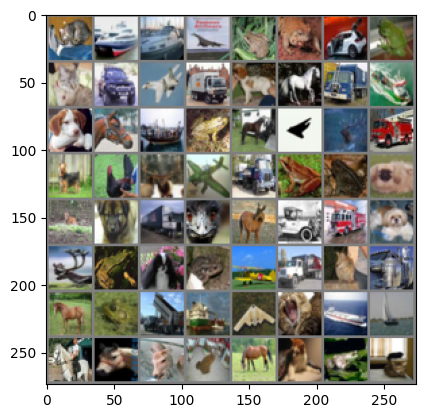

GroundTruth:  cat   ship  ship  plane


In [14]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [15]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
outputs = net(images)

In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


In [18]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 60 %


In [19]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.2 %
Accuracy for class: car   is 74.9 %
Accuracy for class: bird  is 56.4 %
Accuracy for class: cat   is 41.3 %
Accuracy for class: deer  is 47.0 %
Accuracy for class: dog   is 36.4 %
Accuracy for class: frog  is 73.9 %
Accuracy for class: horse is 64.0 %
Accuracy for class: ship  is 68.6 %
Accuracy for class: truck is 74.6 %
